# Parameter tweaking

In [1]:
import pdal 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.linalg import svd 
from osgeo import ogr
import pyvista as pv
import os
import sys
import open3d as o3d
import json
import time 
import matplotlib.pyplot as plt

from interessant import * # Bei Änderungen Kernel neu starten

sys.path.append("/home/riannek/code/gleis/gleisachse")
from algs.centralpoints import *
from algs.voxelfilter import *
from algs.gpkg import get_bbox_polygon
from algs.pca import pca

from scipy.spatial.transform import Rotation as R
ogr.UseExceptions()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
run24 = "/media/riannek/minimax/gleis/run24-2024-08-13"
run14 = "/media/riannek/minimax/gleis/run14-2024-08-14"

runfolder = run24


# Bahnsteig: 29; Gleis hohe Intensität: 11; Weiche B: 16; Unterirdischer Bhf: 20; Gleis weit abseits: 23; Betondeckel: 28; Zug run 14 A: 6; 
# Viele Gleise: 33; Anfang Weiche: 34; OLA gleiche H: 35; Y: 37; Auch viele Gleise: 43; Kreuzung: 44, 45; 47: Drei; 48 Gestrüpp

key = list(interessant.keys())[48] 

filename = interessant[key]



if not os.path.exists(os.path.join(runfolder, filename)):
    raise FileNotFoundError(filename)



In [ ]:
thresh_side_distance = 0.15   # 0.1 ist meist gut, aber in manchen Fällen zu wenig (z.B. Anfang Weiche)

intensity_threshold = 14500
seedpoint_distance = 0.45 # 0.4
neighborhood_radius = 0.5 # 0.5

cluster_minimum_points = 10
minimum_in_hood = 10
linearity_tresh = 0.98

gauge = 1.435
railhead_width = 0.067

tile_size = 25          # side length of each file
voxelcount = 30 

voxel_empty_space_thresh = 10 # 10 good for low noise data
voxel_top_percentile = 99.5   # 99.5 good for low noise data, with noise try 98

voxel_majority_thresh = 0.5
voxel_minimum_points = 50
voxel_ground_percentile = 10
max_rail_above_ground

upperpercentile=90
lowerpercentile = 70

In [4]:

import subprocess
# subprocess.Popen(["pyvistaviewer", os.path.join(runfolder, filename.split(".")[0] + ".copc.laz")])

## Voxel Filter

In [5]:
voxel_size = tile_size / voxelcount

constraints = GeometryConstraints(
    voxel_size, 
    voxel_minimum_points, 
    voxel_empty_space_thresh, 
    voxel_ground_percentile, 
    voxel_top_percentile,
    voxel_majority_thresh, 
    )

In [6]:
points, _ = voxelfilter(
    os.path.join(runfolder, filename), 
    voxel_size,
    constraints,
    cluster_minimum_points,
    "",
    write=False,
    )

if points is None:
    raise ValueError("No rail points found in the file.")

## Seed Points

In [7]:
low_intensity = points[points["Intensity"] < intensity_threshold]
low_intensity.shape

(58874,)

In [8]:
# bounds = f"([{bbox[0]}, {bbox[1]}], [{bbox[2]}, {bbox[3]}])" 
# bounds

In [9]:
# Downsample with poisson sampling (only original bbox)

# downsampling_pipeline = pdal.Filter.crop(bounds=bounds).pipeline(low_intensity) | pdal.Filter("filters.sample", radius=downsample_radius)

downsampling_pipeline = pdal.Filter("filters.sample", radius=seedpoint_distance).pipeline(low_intensity)
downsampling_pipeline.execute()
seed_points = downsampling_pipeline.arrays[0]
seed_point_count = seed_points.shape[0]
seed_point_count

429

In [10]:
xyz = np.vstack((points['X'], points['Y'], points['Z'])).transpose()
xyz_seed = np.vstack((seed_points['X'], seed_points['Y'], seed_points['Z'])).transpose()

In [11]:
offset = xyz.mean(axis=0) # .round() 
xyz -= offset
xyz_seed -= offset

## Plot Funktionen

In [12]:
def plot_cluster_pair(cluster, cluster_other, transformmatrix, representive_a, representive_b, railhead_width = 0.067): 
    """
    """
    center = (cluster.sum(axis=0) + cluster_other.sum(axis=0)) / (cluster.shape[0] + cluster_other.shape[0])
    center_cluster = cluster.mean(axis=0)
    center_other = cluster_other.mean(axis=0)


    cluster = cluster - center_cluster
    cluster_other = cluster_other - center_other


    transformed = cluster @ transformmatrix
    transformed_other = cluster_other @ transformmatrix
    
    representive_a = representive_a - center_cluster
    representive_b = representive_b - center_other
    representive_a = representive_a @ transformmatrix
    representive_b = representive_b @ transformmatrix


    # Check if we need to switch the left, right cluster
    center_cluster_in_pc = (center_cluster - center) @ transformmatrix
    center_other_in_pc = (center_other - center) @ transformmatrix
    if center_cluster_in_pc[0] > center_other_in_pc[0]:
        transformed, transformed_other = transformed_other, transformed
        representive_a, representive_b = representive_b, representive_a
        print("Switched clusters")

    fig, ax = plt.subplots(1,2, figsize=(15, 7))

    ax[0].set_ylim(-0.08, 0.08)
    ax[1].set_ylim(-0.08, 0.08)

    ax[0].axvline(0, color="lightgrey", linestyle="-", zorder=-1)
    ax[0].axhline(0, color="lightgrey", linestyle="-", zorder=-1)
    ax[1].axvline(0, color="lightgrey", linestyle="-", zorder=-1)
    ax[1].axhline(0, color="lightgrey", linestyle="-", zorder=-1)

    ax[0].scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax[0].set_aspect("equal")


    ax[0].axvline(representive_a[0], color="steelblue", linestyle="--", zorder=-1)
    ax[0].axvline(representive_a[0] - (railhead_width/2), color="skyblue", linestyle="--", zorder=-1)
    ax[0].axvline(representive_a[0] + (railhead_width/2), color="skyblue", linestyle="--", zorder=-1)
    ax[0].axhline(representive_a[2], color="steelblue", linestyle="--", zorder=-1)

    ax[1].scatter(transformed_other[:,0], transformed_other[:,2], c=transformed_other[:,1], cmap=plt.cm.plasma, marker=".")
    ax[1].set_aspect("equal")

    ax[1].axvline(representive_b[0], color="steelblue", linestyle="--", zorder=-1)
    ax[1].axvline(representive_b[0] - (railhead_width/2), color="skyblue", linestyle="--", zorder=-1)
    ax[1].axvline(representive_b[0] + (railhead_width/2), color="skyblue", linestyle="--", zorder=-1)
    ax[1].axhline(representive_b[2], color="steelblue", linestyle="--", zorder=-1)

    plt.show()
    return fig, ax, transformed, transformed_other

In [13]:
def plot_cluster(cluster, eigenvects=None): 
    center = cluster.mean(axis=0)
    centered = cluster - center

    if eigenvects is None:
        eigenvals, eigenvects = pca(cluster)

    transformed = centered @ eigenvects
    fig, ax = plt.subplots(figsize=(10, 15))
    ax.scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax.set_aspect("equal")
    plt.show()
    return fig, ax

## Als Funktion

In [14]:
def get_points(xyz, xyz_seed):
    points = []
    lines = []
    tree = KDTree(xyz)  

    # indices: ndarray (dtype object) with a list of indices for each seed point
    indices = tree.query_ball_point(xyz_seed, r=neighborhood_radius, workers=-1)
    seed_point_count = len(xyz_seed)

    for cluster, clustercenter, cluster_other, center_other, eigenvects in pair_generator(xyz, tree, indices, seed_point_count, gauge):
        transformmatrix = get_transformmatrix(cluster, cluster_other, clustercenter, center_other, eigenvects)
        representative_a, side_a  = representative_point(cluster, transformmatrix, railhead_width, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile) 
        representative_b, side_b = representative_point(cluster_other, transformmatrix, railhead_width, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile)

        if representative_a is None or representative_b is None:
            # Happens in rare cases at switches
            continue
        
        # Check if both are classified as the same side
        # but a zero and non zero value is not a problem
        if side_a * side_b < 0:
            # Update the cluster with lower confidence of the side estimation
            if np.abs(side_a) < np.abs(side_b):
                representative_a, side_a  = representative_point(cluster, transformmatrix, railhead_width, side=side_b, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile)
            else:
                representative_b, side_b = representative_point(cluster_other, transformmatrix,  railhead_width, side=side_a, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile)

        if representative_a is None or representative_b is None:
            # Happens in rare cases at switches
            continue

        central = get_central_point(representative_a, representative_b)
        points.append(central)
        points.append(representative_a)
        points.append(representative_b)
        lines.append(pv.Line(representative_a, representative_b))

    return np.array(points), lines


In [15]:
start = time.time()
mypoints, lines = get_points(xyz, xyz_seed)
print(time.time() - start)
pv_mypoints = pv.PolyData(mypoints)

0.7453198432922363


## Visualisierung

In [16]:
pv_all = pv.PolyData(xyz)
pv_seed = pv.PolyData(xyz_seed) 
with_lines = True

In [17]:

p = pv.Plotter()

if with_lines:
    # Add lines (SLOW)
    # for color, line in zip(side_distances, lines):
    #     p.add_mesh(line, scalars=color, cmap='plasma')
    for line in lines:
        p.add_mesh(line, color="red")

p.add_mesh(pv_all, color='gray', point_size=2)
p.add_mesh(pv_mypoints, color="green", point_size=3)

# labels = [str(i) for i in range(len(center_points))]
# p.add_point_labels(pv_centerpoints, labels, point_color="black", font_size=12)

p.show()

# Farbe: Punkte nach "z" oder "diff_z" oder "distance"

Widget(value='<iframe src="http://localhost:44245/index.html?ui=P_0x7fd7322056d0_0&reconnect=auto" class="pyvi…

## Einzeln

In [18]:
tree = KDTree(xyz)  
indices = tree.query_ball_point(xyz_seed, r=neighborhood_radius, workers=-1)
seed_point_count = len(xyz_seed)

pair_gen = pair_generator(xyz, tree, indices, seed_point_count, gauge)

In [19]:
for i in range(30):
    next(pair_gen)

Sides -0.030303030303030304 -0.2
Points per Cluster 65 108
Switched clusters


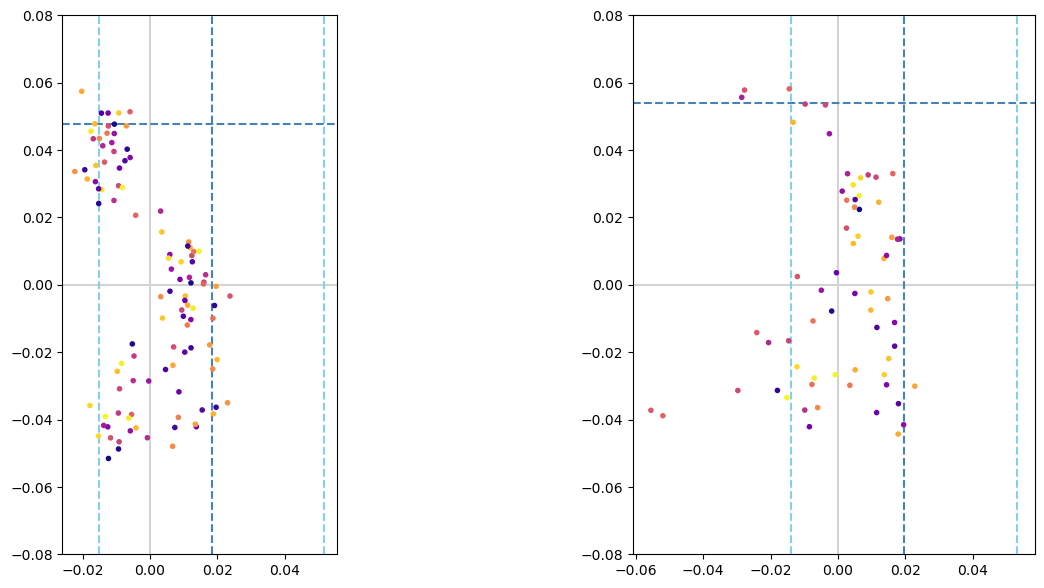

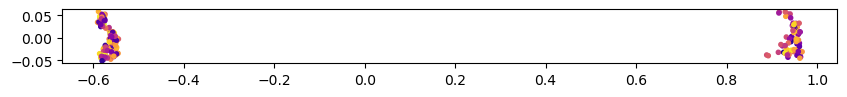

In [20]:
cluster, clustercenter, cluster_other, clustercenter_other, eigenvects = next(pair_gen)

transformmatrix = get_transformmatrix(cluster, cluster_other, clustercenter, clustercenter_other, eigenvects)


representative_a, side_a  = representative_point(cluster, transformmatrix, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile, railhead_width=0.067)
representative_b, side_b = representative_point(cluster_other, transformmatrix, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile, railhead_width=0.067)

print("Sides", side_a, side_b)

# Check if both are classified as the same side
# but a zero and non zero value is not a problem
if side_a * side_b < 0:
    print("Different sides")
    # Update the cluster with lower confidence of the side estimation
    if np.abs(side_a) < np.abs(side_b):
        representative_aaa, side_a  = representative_point(cluster, transformmatrix, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile, railhead_width=0.067, side=side_b)
    else:
        representative_bbb, side_b = representative_point(cluster_other, transformmatrix, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile, railhead_width=0.067, side=side_a)



central = get_central_point(representative_a, representative_b)

print("Points per Cluster", len(cluster), len(cluster_other))
fig, ax, transformed, transformed_other = plot_cluster_pair(cluster, cluster_other, transformmatrix, representative_a, representative_b, railhead_width = 0.067)

pair = np.vstack((cluster, cluster_other))
plot_cluster(pair, transformmatrix);


In [21]:
pcd_clusters = o3d.geometry.PointCloud()
pcd_clusters.points = o3d.utility.Vector3dVector(pair)
pcd_clusters.paint_uniform_color([0, 0, 1])

pcd_clustercenters = o3d.geometry.PointCloud()
pcd_clustercenters.points = o3d.utility.Vector3dVector([clustercenter, clustercenter_other])
pcd_clustercenters.paint_uniform_color([0, 1, 0])

pcd_all = o3d.geometry.PointCloud()
pcd_all.points = o3d.utility.Vector3dVector(xyz)
pcd_all.paint_uniform_color([0.7, 0.7, 0.7])

pcd_representative = o3d.geometry.PointCloud()
pcd_representative.points = o3d.utility.Vector3dVector([representative_a, representative_b, central])
pcd_representative.paint_uniform_color([1, 0, 0])

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])

o3d.visualization.draw_geometries([pcd_all, pcd_clusters, mesh_frame, pcd_clustercenters, pcd_representative])

# Experimentieren